
# NeuroSummarize — Model Evaluation 

This notebook evaluates multiple summarization models on the gold dataset and reports:

- **ROUGE-L, BLEU**
- **Entity-level Precision/Recall/F1**
- **Hallucination rate**
- **Clinical Utility (Likert mean)**
- **Comparative visualizations** (grouped bars, radar, boxplots)

It reads models dynamically from `config/config.yaml` and reuses repo code in `src/evaluate_models.py`.


In [1]:

# If you run this inside your project root (recommended), no changes are needed.
# If running elsewhere, set PROJECT_ROOT to the absolute path of your repo.
import os, sys
from pathlib import Path

PROJECT_ROOT = Path.cwd()
SRC_DIR = PROJECT_ROOT / "src"
CONFIG_DIR = PROJECT_ROOT / "config"

assert SRC_DIR.exists(), f"src/ not found at {SRC_DIR} — run this from project root."
assert (CONFIG_DIR / "config.yaml").exists(), "Missing config/config.yaml"

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

print('Project root:', PROJECT_ROOT)
print('Python path OK.')

Project root: d:\MSc_AI\MSc_Project\NeuroSummarize
Python path OK.


In [15]:
from src.utils.config_loader import load_config, get_models

cfg = load_config()
models_cfg = get_models(cfg)

def _prefix_model(provider: str, model_name: str) -> str:
    # Auto-prefix based on provider for backends used in your code
    provider = (provider or '').strip().lower()
    if provider in ('openai',):
        return f"openai:{model_name}"
    if provider in ('groq',):
        return f"groq:{model_name}"
    # For local/HF keep as-is
    return model_name

# Build a fast & sensible default list
model_ids = []
for provider, settings in (models_cfg or {}).items():
    name = settings.get("model_name")
    if not name:
        continue
    model_ids.append(_prefix_model(provider, name))

# De-duplicate while preserving order
seen = set()
model_ids = [m for m in model_ids if not (m in seen or seen.add(m))]

print('Models selected:', model_ids)

Models selected: ['openai:gpt-3.5-turbo', 'groq:groq:llama3-8b-8192', 'facebook/bart-large-cnn']


In [3]:

from pathlib import Path

# Fast defaults — you can tune these
DATA_DIR = Path("data/gold")      # expects .json or .jsonl with gold
OUTPUT_DIR = Path("results/eval") # results and plots
MAX_SAMPLES = None                # set e.g. 50 for a quick pass
DEVICE = None                     # e.g. 'cpu' or 'cuda'

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print('DATA_DIR:', DATA_DIR.resolve())
print('OUTPUT_DIR:', OUTPUT_DIR.resolve())

DATA_DIR: D:\MSc_AI\MSc_Project\NeuroSummarize\data\gold
OUTPUT_DIR: D:\MSc_AI\MSc_Project\NeuroSummarize\results\eval


In [4]:

from src.evaluate_models import (
    load_gold_dataset, Summarizer, evaluate_one_model_on_dataset,
    plot_grouped_metrics, plot_metric_distributions, plot_radar_normalized
)

items = load_gold_dataset(DATA_DIR)
print(f"Loaded {len(items)} eval items.")

d:\anaconda\envs\neuroenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded 138 items from data\gold
Loaded 138 eval items.


In [8]:
import os
from src.utils.config_loader import load_config, get_api_keys

cfg = load_config()
api_keys = get_api_keys(cfg)

if "groq" in api_keys:
    os.environ["GROQ_API_KEY"] = api_keys["groq"]
if "openai" in api_keys:
    os.environ["OPENAI_API_KEY"] = api_keys["openai"]


In [9]:

import json
from pathlib import Path

all_summaries = []
per_case_csvs = []

for model_id in model_ids:
    print('\n=== Evaluating:', model_id, '===')
    s = Summarizer(clinical_model=model_id, lay_model=model_id, device=DEVICE)
    model_out_dir = OUTPUT_DIR / model_id.replace(':','_')
    model_out_dir.mkdir(parents=True, exist_ok=True)
    
    summary = evaluate_one_model_on_dataset(
        model_id=model_id,
        items=items,
        summarizer=s,
        max_samples=30,
        save_dir=model_out_dir
    )
    all_summaries.append(summary)
    
    per_case = model_out_dir / f"{model_id.replace(':','_')}_per_case.csv"
    if per_case.exists():
        per_case_csvs.append(per_case)

# Save aggregate summary
import pandas as pd
if all_summaries:
    agg_csv = OUTPUT_DIR / "aggregate_summary.csv"
    pd.DataFrame(all_summaries).to_csv(agg_csv, index=False)
    with open(OUTPUT_DIR / "aggregate_summary.json", "w", encoding="utf-8") as f:
        json.dump(all_summaries, f, indent=2)

print('\nDone. Summaries:', len(all_summaries))
if all_summaries:
    import pandas as pd
    display(pd.DataFrame(all_summaries))


=== Evaluating: openai:gpt-3.5-turbo ===

=== Evaluating: groq:groq:llama3-8b-8192 ===

=== Evaluating: facebook/bart-large-cnn ===

Done. Summaries: 3


,agg,summary
0,"{'model': 'openai:gpt-3.5-turbo', 'n': 0, 'rou...","{'model': 'openai:gpt-3.5-turbo', 'n': 0, 'mea..."
1,"{'model': 'groq:groq:llama3-8b-8192', 'n': 30,...","{'model': 'groq:groq:llama3-8b-8192', 'n': 30,..."
2,"{'model': 'facebook/bart-large-cnn', 'n': 30, ...","{'model': 'facebook/bart-large-cnn', 'n': 30, ..."


In [11]:
import pandas as pd
pd.DataFrame(all_summaries)

,agg,summary
0,"{'model': 'openai:gpt-3.5-turbo', 'n': 0, 'rou...","{'model': 'openai:gpt-3.5-turbo', 'n': 0, 'mea..."
1,"{'model': 'groq:groq:llama3-8b-8192', 'n': 30,...","{'model': 'groq:groq:llama3-8b-8192', 'n': 30,..."
2,"{'model': 'facebook/bart-large-cnn', 'n': 30, ...","{'model': 'facebook/bart-large-cnn', 'n': 30, ..."


In [12]:
if all_summaries:
    df = pd.DataFrame(all_summaries)
    if 'model' not in df.columns:
        df['model'] = [f"model_{i}" for i in range(len(df))]
    display(df)

,agg,summary,model
0,"{'model': 'openai:gpt-3.5-turbo', 'n': 0, 'rou...","{'model': 'openai:gpt-3.5-turbo', 'n': 0, 'mea...",model_0
1,"{'model': 'groq:groq:llama3-8b-8192', 'n': 30,...","{'model': 'groq:groq:llama3-8b-8192', 'n': 30,...",model_1
2,"{'model': 'facebook/bart-large-cnn', 'n': 30, ...","{'model': 'facebook/bart-large-cnn', 'n': 30, ...",model_2


--- Grouped Metrics ---


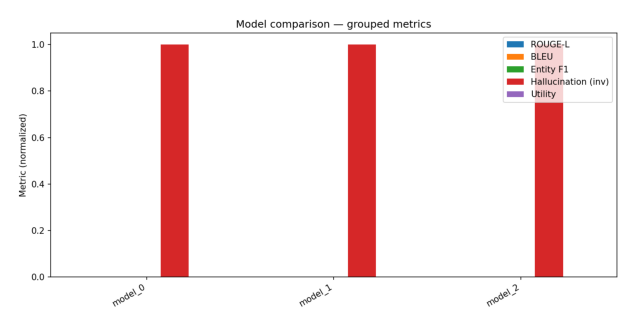

--- Radar (normalized) ---


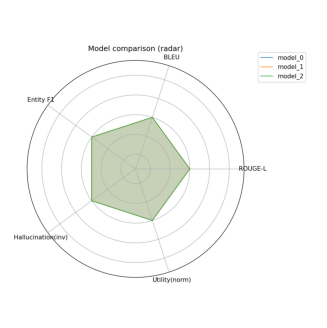

--- Metric Boxplots ---
entity_f


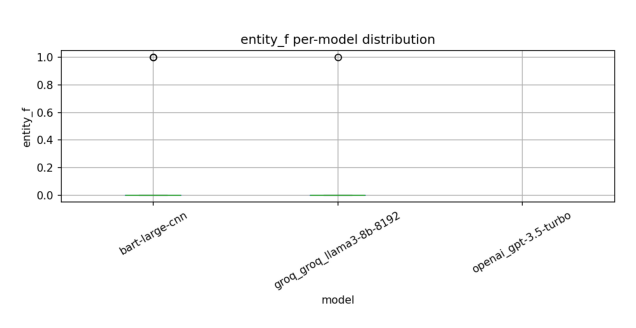

rouge_l_clin


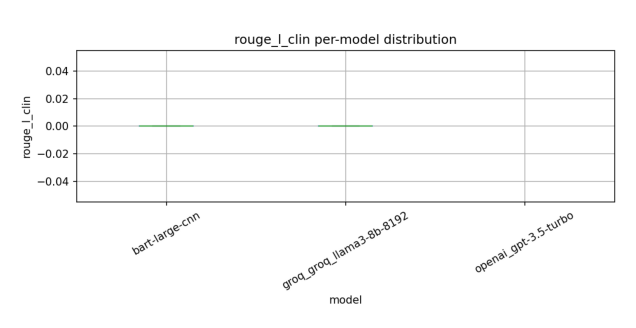

bleu_clin


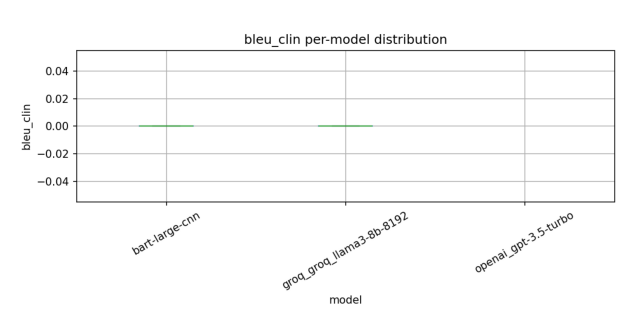

hallucination_rate


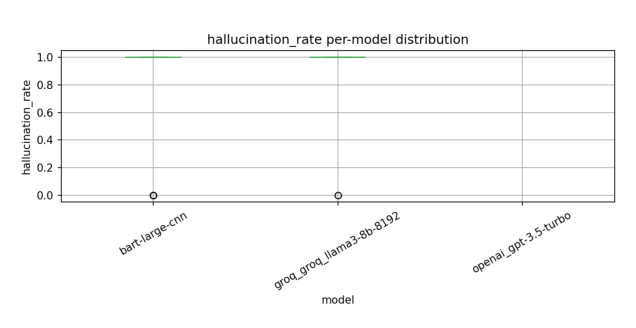

In [14]:
# Generate and display plots inline.
from IPython.display import display
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

PLOTS_DIR = OUTPUT_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

grouped_path = None
radar_path = None
boxplot_paths = {}

# --- Normalize summaries to always have a "model" column ---
norm_summaries = []
for i, s in enumerate(all_summaries):
    if not isinstance(s, dict):
        continue
    if "model" not in s:
        s = {**s, "model": f"model_{i}"}  # add placeholder
    norm_summaries.append(s)

if norm_summaries:
    grouped_path = plot_grouped_metrics(norm_summaries, PLOTS_DIR)
    radar_path = plot_radar_normalized(norm_summaries, PLOTS_DIR)

if per_case_csvs:
    boxplot_paths = plot_metric_distributions(per_case_csvs, PLOTS_DIR)

def _show_png(pathlike):
    try:
        img = Image.open(pathlike)
        plt.figure(figsize=(8,4))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print('Could not display', pathlike, e)

print('--- Grouped Metrics ---')
if grouped_path:
    _show_png(grouped_path)

print('--- Radar (normalized) ---')
if radar_path:
    _show_png(radar_path)

print('--- Metric Boxplots ---')
for k, p in boxplot_paths.items():
    print(k)
    _show_png(p)


In [ ]:

# Optional: compare against targets defined in config.yaml -> evaluation settings
targets = (cfg or {}).get('evaluation', {})

TARGET_F1 = float(targets.get('target_f1', 0.90))
TARGET_ROUGE_L = float(targets.get('target_rouge_l', 0.45))
MAX_HALL_RATE = float(targets.get('max_hallucination_rate', 0.12))
UTILITY_THRESH = float(targets.get('clinical_utility_threshold', 0.80))

import pandas as pd
if all_summaries:
    df = pd.DataFrame(all_summaries)
    # Normalize some columns for safety
    for col in ['entity_f_mean','rouge_l_clin_mean','hallucination_rate_mean','clinical_utility_likert_mean']:
        if col not in df.columns:
            df[col] = 0.0
    df['meets_f1'] = df['entity_f_mean'] >= TARGET_F1
    df['meets_rougeL'] = df['rouge_l_clin_mean'] >= TARGET_ROUGE_L
    df['meets_hallucination'] = df['hallucination_rate_mean'] <= MAX_HALL_RATE
    df['meets_utility'] = df['clinical_utility_likert_mean'] >= UTILITY_THRESH
    display(df[['model','entity_f_mean','rouge_l_clin_mean','hallucination_rate_mean','clinical_utility_likert_mean',
                'meets_f1','meets_rougeL','meets_hallucination','meets_utility']])
else:
    print("No summaries computed; check DATA_DIR and model configs.")


### Tips
- For **fast runs**, set `MAX_SAMPLES` (e.g., 30–50) before running the evaluation cell.
- To try additional models, add them to `config/config.yaml` or append to `model_ids` manually.
- If you use OpenAI or Groq models, ensure your API keys are properly configured in your environment.

### Expected Artifacts
- Per-case CSVs at: `results/eval/<model_id>/*_per_case.csv`
- Aggregate tables: `results/eval/aggregate_summary.csv` and `.json`
- Plots: `results/eval/plots/` (grouped metrics, radar, and metric boxplots)
